# 划分验证集，from训练集，不相交

In [4]:
# import os
# import pandas as pd
# import numpy as np
# import shutil

# dir = "F:\BBBBBBBBBBBBBBBBB\Datas"

# driver_imgs_list_csv = os.path.join(dir, "driver_imgs_list.csv")
# valid_subjects = ['p081','p075']

# # if not os.path.exists(dir + "valid"):
# os.mkdir(dir+"/valid")
# for i in range(10):
#     os.mkdir(dir+"/valid/c%d"%i)

# df = pd.read_csv(driver_imgs_list_csv)
# for valid_subject in valid_subjects:
#     df_valid = df[(df["subject"]==valid_subject)]
#     for index, row in df_valid.iterrows():
#         subpath = row["classname"] + "/" + row["img"]
#         if os.path.exists(os.path.join(dir,"train",subpath)):
#             shutil.move(os.path.join(dir,"train",subpath), os.path.join(dir,"valid",subpath),)
#         else:
#             print("cannot move {} : {}".format(row["subject"],subpath))



# 加载包
load libraries

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

from keras.models import *
from keras.optimizers import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

In [2]:
dir = "F:\BBBBBBBBBBBBBBBBB\Datas"

model_image_size = (320, 480)# 图像高度宽度元组
fine_tune_layer = 172
final_layer = 314
visual_layer = 311
batch_size = 128

# 加载数据集

load train data

In [5]:
train_gen = ImageDataGenerator(
    featurewise_std_normalization=True,    # 对整个训练集进行标准化，确保数据的标准差为1，均值为0。用于特征归一化。
    samplewise_std_normalization=False,    # 不对每个单独的样本进行标准化。若设置为True，数据会按每个图像单独标准化。
    rotation_range=10.,                    # 随机旋转图像的角度范围，这里表示可以随机旋转图像最多 ±10 度。
    width_shift_range=0.05,                # 水平平移范围，表示图像在水平方向上最多可以平移 ±5% 的图像宽度。
    height_shift_range=0.05,               # 垂直平移范围，表示图像在垂直方向上最多可以平移 ±5% 的图像高度。
    shear_range=0.1,                       # 剪切变换的强度，控制图像的倾斜度。
    zoom_range=0.1,                        # 随机缩放的幅度，图像随机缩放范围为 ±10%。
)

gen = ImageDataGenerator(
    featurewise_std_normalization=True,    # 同样开启特征标准化。
    samplewise_std_normalization=False,    # 不对每个图像进行标准化。
)

C:\Users\13904\anaconda3\lib\site-packages\keras\preprocessing\image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


#### train_generator 说明：
- flow_from_directory()：这是 ImageDataGenerator 的一个方法，用于从指定目录加载图像。该方法会按目录结构自动将文件分类，并对图像进行预处理和增强。
- os.path.join(dir, 'train')：这是图像数据集的训练集目录路径，假设 dir 是一个已定义的变量，表示数据集的根目录。
- model_image_size：此参数是一个元组，表示模型输入图像的尺寸。通常用于调整所有输入图像的大小，使其一致（例如 (224, 224) 适用于许多 CNN 模型）。
- shuffle=True：表示每个批次图像在生成之前会被打乱顺序，这有助于避免模型在训练时因数据顺序产生偏差。
- batch_size=batch_size：每个批次加载的样本数量。batch_size 是一个预定义的变量，通常是 32、64 或 128。
- class_mode="categorical"：表示标签采用类别编码的方式。如果分类是多类标签，通常使用 categorical。其他选项包括 binary（二分类）和 sparse（稀疏分类）。
#### valid_generator 说明：
- valid_generator 与 train_generator 类似，只不过它加载的是验证集数据，路径为 os.path.join(dir, 'valid')，这表示验证集图像存储在 valid 文件夹中。
- 其他参数与 train_generator 相同。

In [6]:
train_generator = train_gen.flow_from_directory(os.path.join(dir, 'train'),  model_image_size, shuffle=True, batch_size=batch_size, class_mode="categorical")
print("subdior to train type {}".format(train_generator.class_indices))

Found 20787 images belonging to 10 classes.
subdior to train type {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


In [7]:
valid_generator = gen.flow_from_directory(os.path.join(dir, 'valid'),  model_image_size, shuffle=True, batch_size=batch_size, class_mode="categorical")
print("subdior to valid type {}".format(valid_generator.class_indices))

Found 1637 images belonging to 10 classes.
subdior to valid type {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/inceptionV3.py

构建一个迁移学习模型，使用预训练的 InceptionV3 网络作为特征提取器，添加自定义的全局池化、Dropout 和全连接层来进行分类任务。模型使用 ImageNet 上的预训练权重，避免从头开始训练，从而提高效率并利用预训练的知识。

- 输入层：定义输入的图像大小和通道数。
- 预处理：使用 InceptionV3 的预处理函数对输入进行标准化。
- 基础模型：加载预训练的 InceptionV3 网络（不包含顶层分类部分）。
- 自定义层：添加全局平均池化、Dropout 和全连接层进行分类。
- 冻结层：可选，冻结前几层的权重以加速训练。

这个模型适合做 迁移学习，特别是在你的数据集相对较小的时候，可以有效地利用大规模数据集（如 ImageNet）的知识。


In [8]:
# input_tensor 现在是一个张量对象，表示模型的输入数据
input_tensor = Input((*model_image_size, 3))# 输入层，model_image_size：包含图像高度和宽度的元组，
                                            # 3：表示图像的通道数，对于 RGB 图像，通道数是 3         
# 预处理输入:
"""
这一行使用了 Keras 中的 Lambda 层，该层将执行自定义的操作。
在这里，inception_v3.preprocess_input 是 InceptionV3 网络的预处理函数，
它会对输入图像进行标准化或其他必要的预处理操作，例如减去均值等，使得图像数据适合 InceptionV3 网络的输入。
"""
x = input_tensor
x = Lambda(inception_v3.preprocess_input)(x)

# 加载 InceptionV3 基础模型：
"""
input_tensor=x：指定前面定义的 x 作为输入。
weights='imagenet'：加载在 ImageNet 数据集上预训练的权重。这使得模型具有较强的特征提取能力。
include_top=False：不包含 InceptionV3 网络的全连接层（即顶层）。
这意味着我们将使用 InceptionV3 作为一个特征提取器，而不是完整的分类模型。返回的是卷积层的输出。
"""
base_model = InceptionV3(input_tensor=x, weights='imagenet', include_top=False)

# 添加自定义分类层：
x = GlobalAveragePooling2D()(base_model.output) # 全局平均池化层，用于将每个通道的特征图输出转换为一个数字，减少特征图的维度。
                                                # 对于每个通道，池化层输出该通道所有像素的平均值。
                                                # 这一操作可以减少模型的参数数量，并提高模型的泛化能力。
x = Dropout(0.5)(x) # Dropout 层用于在训练过程中随机“丢弃”50%的神经元（0.5 表示丢弃率为 50%）。
                    # 这种正则化方法有助于防止模型过拟合。
x = Dense(10, activation='softmax')(x)  # 全连接层，输出 10 个神经元（假设是 10 类分类问题）。
                                        # 使用 softmax 激活函数，使得输出值表示为概率分布。
                                        # softmax 函数会将输出值归一化，使得所有输出值的和为 1，因此可以用来进行多类别分类。
# 创建模型：
""" 
Keras 的 Model 类，用于创建最终的模型。
base_model.input 表示模型的输入是通过 InceptionV3 模型定义的输入，而 x 是我们添加的自定义输出层。
"""
model = Model(base_model.input, x)

# 打印总层数：
print("total layer count {}".format(len(base_model.layers)))

# 冻结某些层（可选）：
"""
for i in range(fine_tune_layer)：遍历前 fine_tune_layer 层。
model.layers[i].trainable = False：冻结这些层，使得它们在训练过程中不会更新权重。
    这样做的目的是使用预训练的 InceptionV3 模型作为特征提取器，只训练新增的自定义层，从而加速训练和防止过拟合。
fine_tune_layer 是一个参数，表示我们冻结多少层。
    通常在迁移学习中，可以冻结较低层（已经学到了通用特征），只训练高层（适应特定任务）。

"""
for i in range(fine_tune_layer):
    model.layers[i].trainable = False

total layer count 312


# 训练模型

In [9]:
print("train_generator.samples = {}".format(train_generator.samples))
print("valid_generator.samples = {}".format(valid_generator.samples))
steps_train_sample = train_generator.samples // 128 + 1
steps_valid_sample = valid_generator.samples // 128 + 1

train_generator.samples = 20787
valid_generator.samples = 1637


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=4, validation_data=valid_generator, validation_steps=steps_valid_sample)

model.save("models/inceptionV3-imagenet-finetune{}-adam.h5".format(fine_tune_layer))
print("model saved!")

C:\Users\13904\AppData\Local\Temp\ipykernel_11428\1893122144.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=4, validation_data=valid_generator, validation_steps=steps_valid_sample)
C:\Users\13904\anaconda3\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
C:\Users\13904\anaconda3\lib\site-packages\keras\preprocessing\image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/4
163/163 [==============================] - 2173s 13s/step - loss: 0.1537 - accuracy: 0.9519 - val_loss: 0.4573 - val_accuracy: 0.8528
Epoch 2/4
163/163 [==============================] - 2608s 16s/step - loss: 0.0370 - accuracy: 0.9890 - val_loss: 0.6000 - val_accuracy: 0.8454
Epoch 3/4
163/163 [==============================] - 2221s 14s/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.4690 - val_accuracy: 0.8479
Epoch 4/4
163/163 [==============================] - 2176s 13s/step - loss: 0.0186 - accuracy: 0.9947 - val_loss: 0.4469 - val_accuracy: 0.8797
model saved!


In [11]:
model.compile(optimizer=RMSprop(lr=1*0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=6, validation_data=valid_generator, validation_steps=steps_valid_sample)

model.save("models/inceptionV3-imagenet-finetune{}.h5".format(fine_tune_layer))
print("model saved!")

C:\Users\13904\anaconda3\lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\13904\AppData\Local\Temp\ipykernel_11428\2508737129.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_train_sample, epochs=6, validation_data=valid_generator, validation_steps=steps_valid_sample)


Epoch 1/6
163/163 [==============================] - 2174s 13s/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.4089 - val_accuracy: 0.8833
Epoch 2/6
163/163 [==============================] - 2095s 13s/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.4173 - val_accuracy: 0.8821
Epoch 3/6
163/163 [==============================] - 2091s 13s/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.4295 - val_accuracy: 0.8864
Epoch 4/6
163/163 [==============================] - 2090s 13s/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.4618 - val_accuracy: 0.8784
Epoch 5/6
163/163 [==============================] - 2090s 13s/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.4566 - val_accuracy: 0.8839
Epoch 6/6
163/163 [==============================] - 2094s 13s/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.4733 - val_accuracy: 0.8797
model saved!


# 可视化模型

https://keras.io/visualization/

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import *

model = load_model("models/inceptionV3-imagenet-finetune{}.h5".format(fine_tune_layer))
print("load successed")

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

load successed


# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 X\*X
* P: 概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 X\*X\*2048

In [13]:
z = zip([x.name for x in model.layers], range(len(model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_1 - 0
lambda - 1
conv2d - 2
batch_normalization - 3
activation - 4
conv2d_1 - 5
batch_normalization_1 - 6
activation_1 - 7
conv2d_2 - 8
batch_normalization_2 - 9
activation_2 - 10
max_pooling2d - 11
conv2d_3 - 12
batch_normalization_3 - 13
activation_3 - 14
conv2d_4 - 15
batch_normalization_4 - 16
activation_4 - 17
max_pooling2d_1 - 18
conv2d_8 - 19
batch_normalization_8 - 20
activation_8 - 21
conv2d_6 - 22
conv2d_9 - 23
batch_normalization_6 - 24
batch_normalization_9 - 25
activation_6 - 26
activation_9 - 27
average_pooling2d - 28
conv2d_5 - 29
conv2d_7 - 30
conv2d_10 - 31
conv2d_11 - 32
batch_normalization_5 - 33
batch_normalization_7 - 34
batch_normalization_10 - 35
batch_normalization_11 - 36
activation_5 - 37
activation_7 - 38
activation_10 - 39
activation_11 - 40
mixed0 - 41
conv2d_15 - 42
batch_normalization_15 - 43
activation_15 - 44
conv2d_13 - 45
conv2d_16 - 46
batch_normalization_13 - 47
batch_normalization_16 - 48
activation_13 - 49
activation_16 - 50
average_pooling2

http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [21]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    test_dir = os.path.join(dir,  "test" )
    image_files = glob.glob(os.path.join(test_dir,"*"))
    print(len(image_files))
    
    plt.figure(figsize=(12, 24))
    for i in range(10):
        plt.subplot(5, 2, i+1)
        img = cv2.imread(image_files[2000*i+113])
        img = cv2.resize(img,  (model_image_size[1],model_image_size[0]))
        x = img.copy()
        x.astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        out = out[0]
        
        max_idx = np.argmax(predictions)
        prediction = predictions[max_idx]

        status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]

        plt.title('c%d |%s| %.2f%%' % (max_idx , status[max_idx], prediction*100))
    
        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam = cam[:,:,max_idx]
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (model_image_size[1],model_image_size[0]))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


layer_output KerasTensor(type_spec=TensorSpec(shape=(None, 8, 13, 2048), dtype=tf.float32, name=None), name='mixed10/concat:0', description="created by layer 'mixed10'")
weights shape (2048, 10)
79726
1/1 [==============================] - 0s 87ms/step


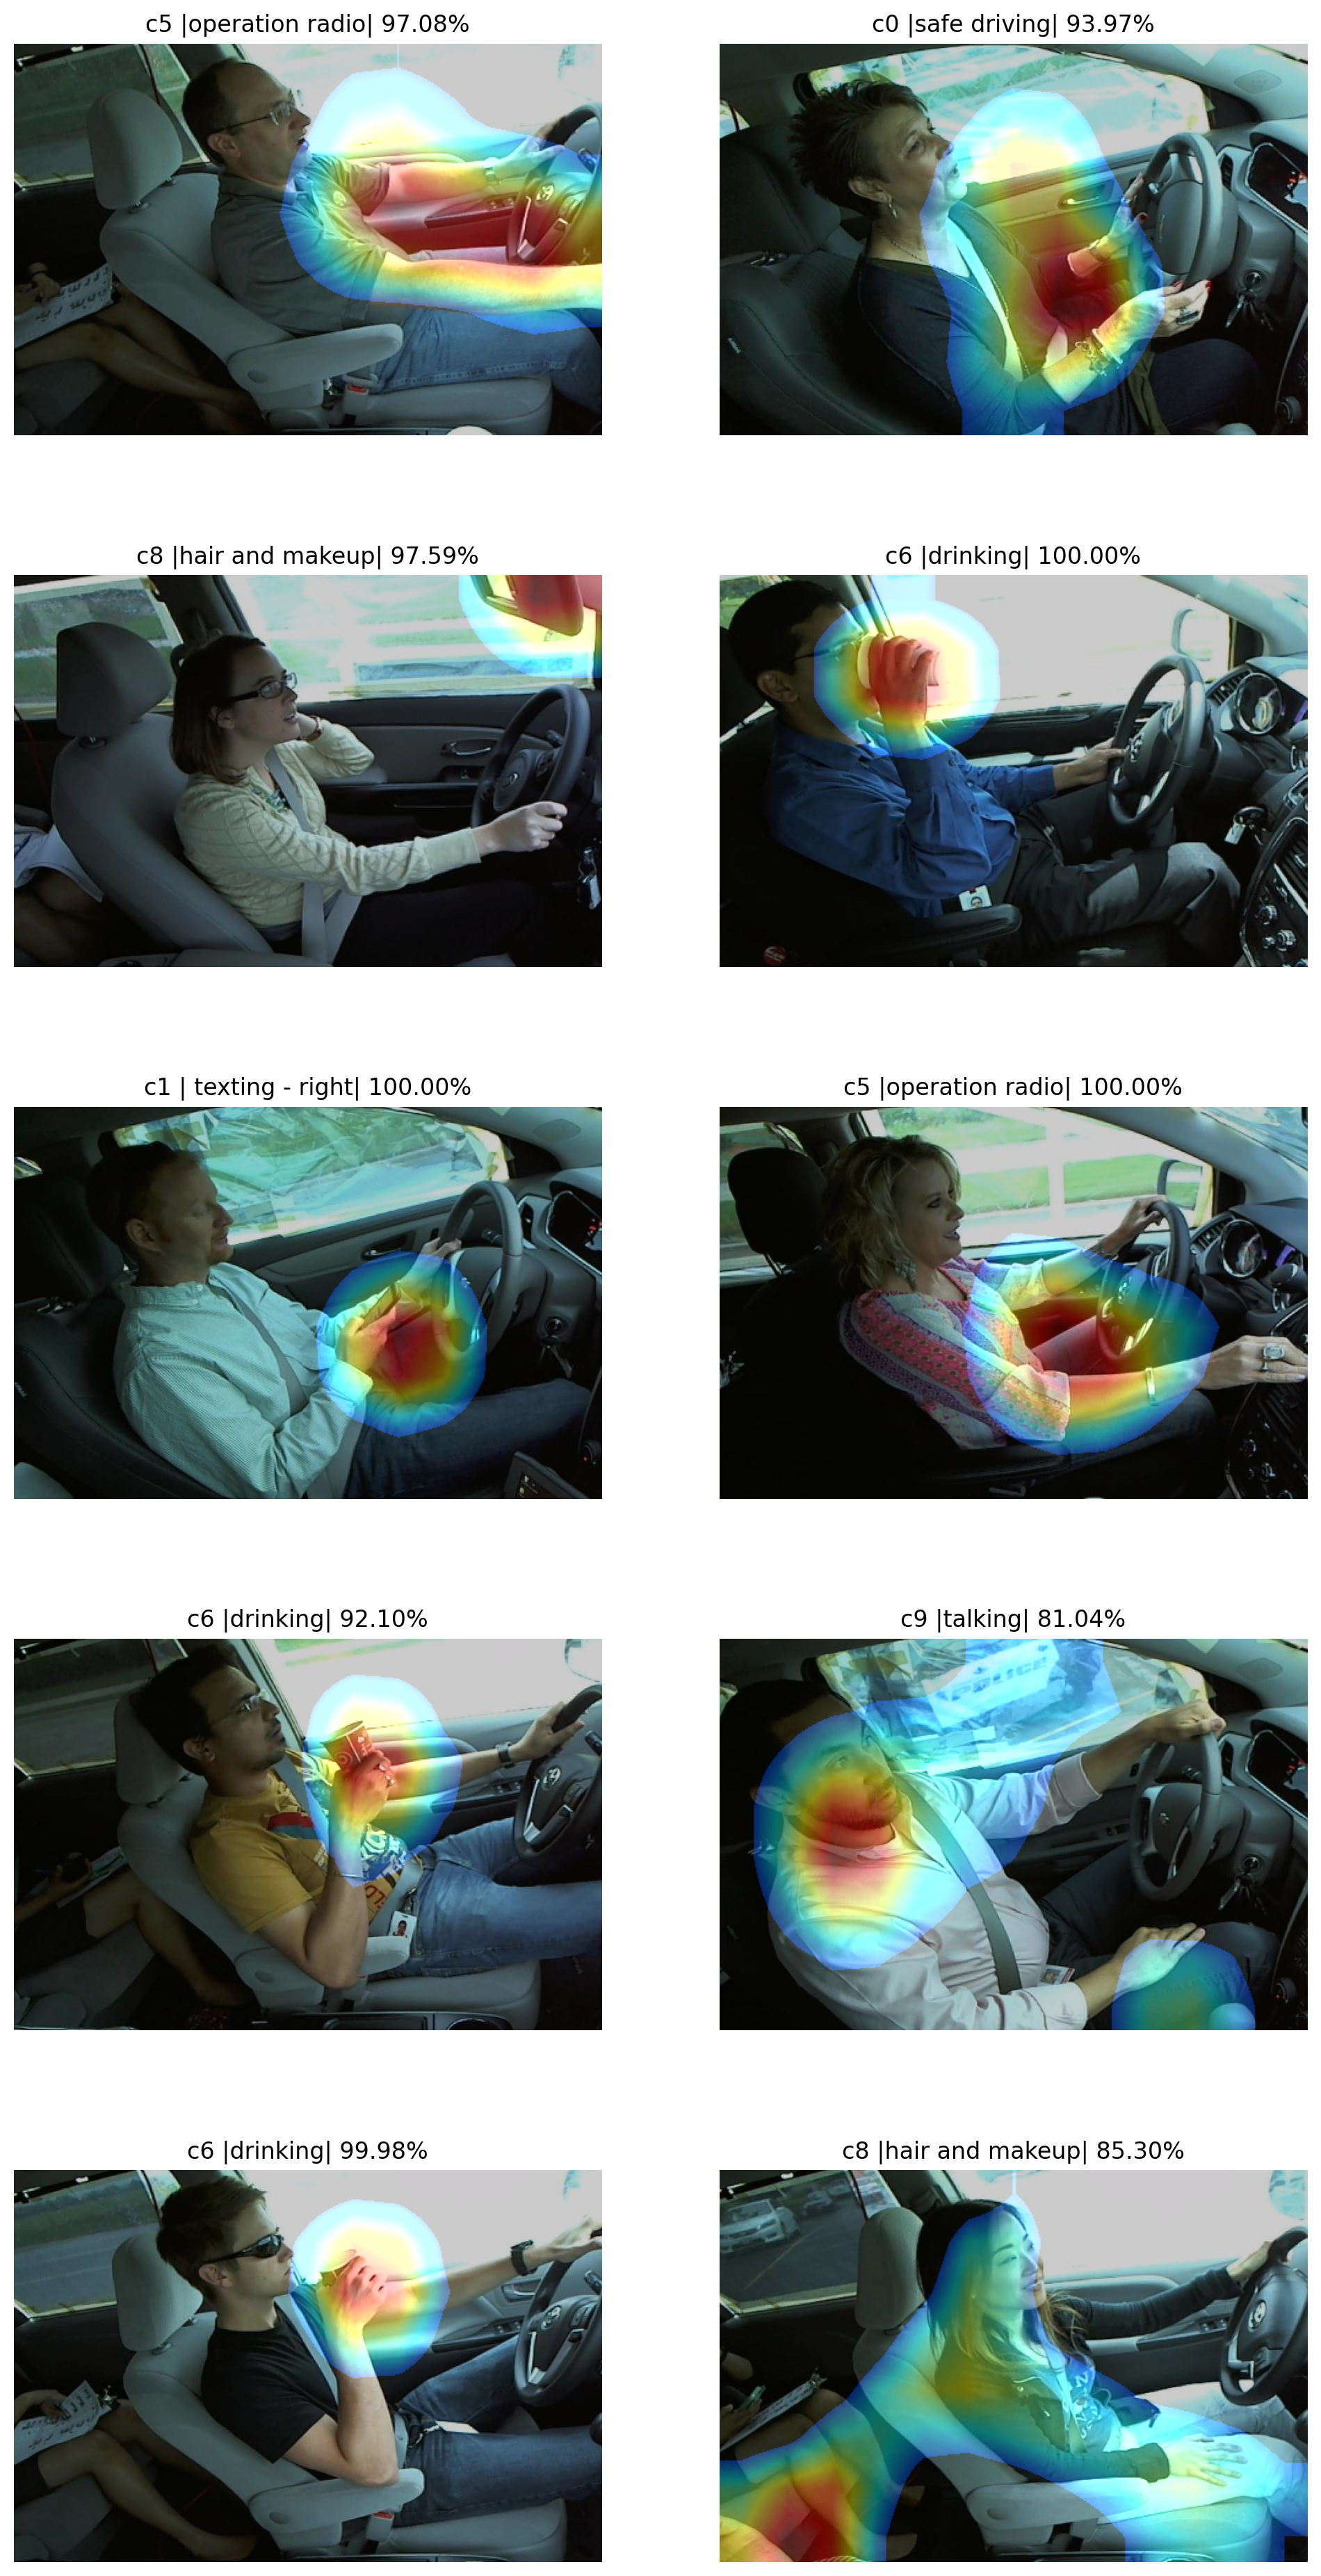

In [22]:
weights = model.layers[final_layer].get_weights()[0]
layer_output = model.layers[visual_layer].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)

In [23]:
def gen_kaggle_csv(model,  model_image_size, csv_name):
    dir = "/ext/Data/distracted_driver_detection/"

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(dir + "test/",  model_image_size, shuffle=False, 
                                             batch_size=batch_size, class_mode=None)
#     s = test_generator.__dict__
#     del s['filenames']
#     print(s)
    y_pred = model.predict_generator(test_generator,  steps=test_generator.samples//batch_size+1,  verbose=1)
    print("y_pred shape {}".format(y_pred.shape))
    y_pred = y_pred.clip(min=0.005, max=0.995)
    print(y_pred[:3])

    l = list()
    for i, fname in enumerate(test_generator.filenames):
        name = fname[fname.rfind('/')+1:]
        l.append( [name, *y_pred[i]] )

    l = np.array(l)
    data = {'img': l[:,0]}
    for i in range(10):
        data["c%d"%i] = l[:,i+1]
    df = pd.DataFrame(data, columns=['img'] + ['c%d'%i for i in range(10)])
    df.head(10)
    df = df.sort_values(by='img')
    df.to_csv(csv_name, index=None, float_format='%.3f')
    print("csv saved")

print("done")

done


In [24]:
gen_kaggle_csv(model,  model_image_size, 'csv/InceptionV3-imagenet-finetune{}-pred.csv'.format(fine_tune_layer))

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '/ext/Data/distracted_driver_detection/test/'